In [75]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from sklearn import metrics
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, Lasso, LassoCV
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)


# Data Import

The data used for this project is New York Ciry's energy use 2021 and got from Urban Green Council website.

In [76]:
nyc_df = pd.read_csv('../data/nyc-bldg2021.csv')
nyc_df = nyc_df.replace(['Not Available', 'Insufficient access'], np.nan)

# portion of missing data for each feature
missing_df = pd.DataFrame(100 * nyc_df.isna().sum()/len(nyc_df))
missing_df.loc[missing_df[0] < 80, :]

/var/folders/cb/7tm32xh579bd23nj5kz1sydc0000gp/T/ipykernel_9335/1595540704.py:1: DtypeWarning: Columns (10,25,32,137,138,139,142,143,144,145,146,147,148,149,206,207) have mixed types. Specify dtype option on import or set low_memory=False.
  nyc_df = pd.read_csv('../data/nyc-bldg2021.csv')


,0
Property.Type,0.000000
Property.Id,0.000000
Property.Name,0.000000
Year.Ending,0.000000
NYC.Borough..Block.and.Lot..BBL.,0.187655
NYC.Building.Identification.Number..BIN.,0.187655
Address.1,0.000000
City,0.000000
Postal.Code,0.000000
Primary.Property.Type...Portfolio.Manager.Calculated,0.006702


# Feature Engineering

In this section unusefull data are removed or replaced with NAs. Also new variables base on original features are defined.

In [77]:
# Replacing unuseful data with NA value
nyc_df['Property.Type'] = np.where(nyc_df['Property.Type'] == 'Wastewater Treatment Plant', np.nan, nyc_df['Property.Type'])

nyc_df['Property.Type'] = np.where(nyc_df['Property.Type'] == 'Other', np.nan, nyc_df['Property.Type'])

nyc_df['Property.Type'] = np.where(nyc_df['Property.Type'] == 'Supermarket/Grocery Store', np.nan, nyc_df['Property.Type'])

nyc_df['Property.Type'] = np.where(nyc_df['Property.Type'] == 'Medical Office', np.nan, nyc_df['Property.Type'])

nyc_df['Multifamily.Housing.Government.Subsidized.Housing'] = np.where(nyc_df['Multifamily.Housing.Government.Subsidized.Housing'] == '100% Yes', 'Yes', nyc_df['Multifamily.Housing.Government.Subsidized.Housing'])

# Categorizing features
nyc_df['number.of.energy.meters.cat'] = pd.cut(nyc_df['Number.of.Active.Energy.Meters.Used.to.Compute.Metrics'], 
       bins=[0, 5, 10, 15, 20, 25, 30], 
       include_lowest=True, 
       labels=['5', '10', '15', '20', '25', '25+'])

nyc_df['Occupancy'] = pd.cut(nyc_df['Occupancy'], 
        bins=[0, 10, 20, 30, 40, 60, 70, 80, 90, 100], 
        include_lowest=True, 
       labels=[10, 20, 30, 40, 60, 70, 80, 90, 100])

nyc_df['Occupancy100'] = (nyc_df['Occupancy'] == 100)

nyc_df['building_age'] = 2021 - nyc_df['Year.Built']

nyc_df['ENERGY.STAR.Score'] = nyc_df['ENERGY.STAR.Score'].astype(float)
nyc_df['ENERGY.STAR.Score.letter'] = pd.cut(nyc_df['ENERGY.STAR.Score'], 
      bins=[0, 54, 69, 84, 110], 
       include_lowest=True, 
       labels=['D', 'C', 'B', 'A'])


In [78]:
# Renaming selected features:
nyc_df.rename(columns={"Estimated.Data.Flag...Natural.Gas": "estimated_gas_usage",
                   "Estimated.Data.Flag...Electricity..Grid.Purchase.": "estimated_electricity_usage",
                   "Multifamily.Housing.Resident.Population.Type": "multifamily_pop_type", 
                   "Multifamily.Housing.Government.Subsidized.Housing": "subsidized_housing", 
                   "Multifamily.Housing.Percent.That.Can.Be.Heated": "multifamily_heated_area", 
                   "Multifamily.Housing.Percent.That.Can.Be.Cooled": "multifamily_cooled_area", 
                   "Percent.of.Electricity.Green.Power": "green_electricity_percent", 
                   "Electricity.Use...Grid.Purchase.and.Generated.from.Onsite.Renewable.Systems..kBtu.": "electricity_use", 
                   "ENERGY.STAR.Score": "energy_score", 
                   "Weather.Normalized.Site.Natural.Gas.Intensity..therms.ft..": "normalized_gas_intensity", 
                   "Multifamily.Housing.Gross.Floor.Area.ft": "multifamily_gfa",
                   "Property.GFA.Calculated.Buildings.and.Parking.ft": "property_gfa",
                   "Site.EUI.kBtu.ft": "energy_use"},
                     inplace=True)


## Selecting numeric and categorical features

In [102]:
# Selected Features
cont_vars = list({
    'energy_use'
    #, 'Site.Energy.Use.kBtu'
    #, 'Natural.Gas.Use..kBtu.'
    #, 'Electricity.Use...Grid.Purchase..kBtu.'
    #, 'electricity_use'
    #, 'Total.GHG.Emissions.Intensity.kgCO2e.ft'
    #, 'Total.GHG.Emissions..Metric.Tons.CO2e.'
    #, 'Source.Energy.Use.kBtu'
    , 'green_electricity_percent'
 #   , 'Percent.Total.Electricity.Generated.Onsite.Renewable.Systems'
    , 'building_age'
    , 'energy_score'
 #   , 'LEED.US.Project.ID'
    , 'multifamily_cooled_area'
    , 'multifamily_heated_area'
    , 'Latitude'
    , 'Longitude'
})

cat_vars = list({
 #   'Property.Id'
 #    'Postal.Code',
   # 'City',
   'Property.Type',
   'Occupancy100',
   'Metered.Areas.Energy',
   'number.of.energy.meters.cat',
   #'Target.ENERGY.STAR.Score',
   'subsidized_housing',
 #   , 'Multifamily.Housing...Number.of.Laundry.Hookups.in.All.Units'
   'multifamily_pop_type',
   #, 'Number.of.Active.Energy.Meters.Used.to.Compute.Metrics'
  'Borough',
  'estimated_electricity_usage',
  'estimated_gas_usage'
})

log_vars = list({
 #  'normalized_gas_intensity', 
   'property_gfa', 
   'multifamily_gfa'
 
})

df = nyc_df[cat_vars + cont_vars + log_vars].copy()
df[cont_vars] = df[cont_vars].astype('float64')
df[log_vars] = df[log_vars].astype('float64')
df[cat_vars] = df[cat_vars].astype('category')
#df.columns = df.columns.str.lower().str.replace('.', '_')
print(df.shape)
df.head()

(29842, 19)


,Borough,number.of.energy.meters.cat,multifamily_pop_type,Metered.Areas.Energy,Property.Type,estimated_gas_usage,Occupancy100,estimated_electricity_usage,subsidized_housing,multifamily_cooled_area,energy_score,building_age,multifamily_heated_area,Latitude,green_electricity_percent,Longitude,energy_use,property_gfa,multifamily_gfa
0,MANHATTAN,5,NaN,Whole Property,Adult Education,No,True,No,NaN,NaN,NaN,129.0,NaN,40.765894,0.0,-73.980896,150.4,33497.0,NaN
1,QUEENS,5,NaN,Whole Property,Adult Education,No,True,No,NaN,NaN,NaN,29.0,NaN,40.751163,0.0,-73.951976,31.9,213108.0,NaN
2,MANHATTAN,5,No specific resident population,Whole Property,Adult Education,No,True,No,No,90.0,NaN,95.0,100.0,40.730806,0.0,-73.987364,69.9,41759.0,15689.0
3,BROOKLYN,5,NaN,Whole Property,Adult Education,No,True,No,NaN,NaN,NaN,18.0,NaN,40.623206,0.0,-73.989672,68.8,81000.0,NaN
4,QUEENS,10,NaN,Whole Property,Adult Education,No,True,No,NaN,NaN,NaN,99.0,NaN,40.760330,0.0,-73.829831,66.9,90950.0,NaN


In [103]:
#Checking the features type
df.dtypes

Borough                        category
number.of.energy.meters.cat    category
multifamily_pop_type           category
Metered.Areas.Energy           category
Property.Type                  category
estimated_gas_usage            category
Occupancy100                   category
estimated_electricity_usage    category
subsidized_housing             category
multifamily_cooled_area         float64
energy_score                    float64
building_age                    float64
multifamily_heated_area         float64
Latitude                        float64
green_electricity_percent       float64
Longitude                       float64
energy_use                      float64
property_gfa                    float64
multifamily_gfa                 float64
dtype: object

In [104]:
# saving the selected features dataframe
df.to_csv('../data/nyc-energy-usage-2021.csv')

In [105]:
# Checking NAs
df.isna().sum()

Borough                         1123
number.of.energy.meters.cat      263
multifamily_pop_type           17281
Metered.Areas.Energy            2109
Property.Type                    320
estimated_gas_usage             3240
Occupancy100                       0
estimated_electricity_usage     1611
subsidized_housing             17051
multifamily_cooled_area        10484
energy_score                    6824
building_age                       0
multifamily_heated_area        10484
Latitude                        1129
green_electricity_percent       2060
Longitude                       1129
energy_use                      1981
property_gfa                       2
multifamily_gfa                10481
dtype: int64

In [106]:
df.dropna(inplace=True)

<__array_function__ internals>:5: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


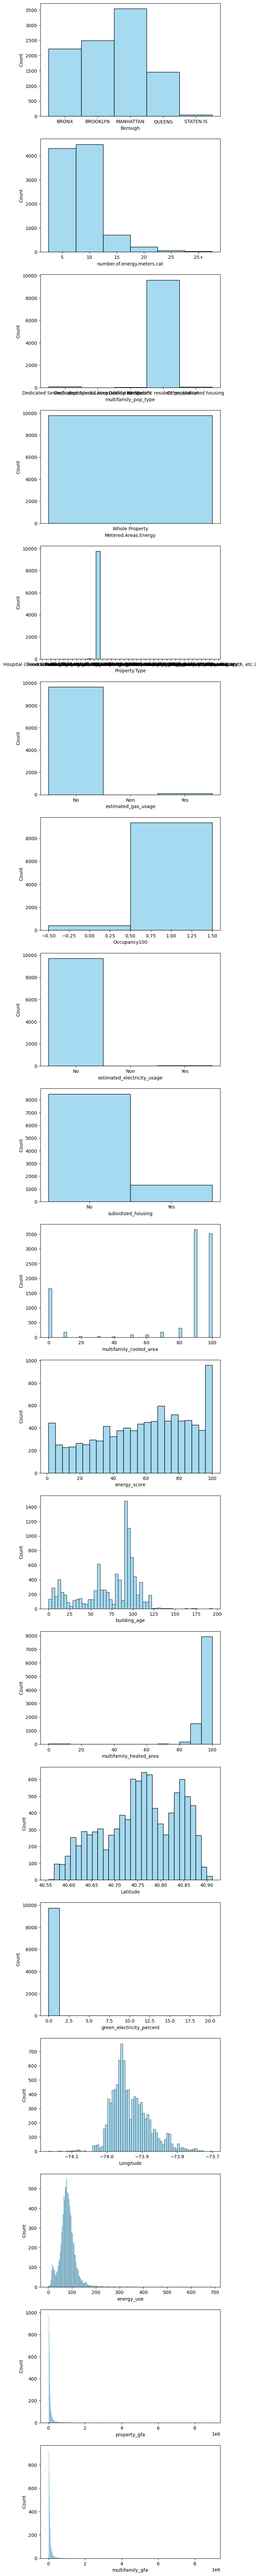

In [107]:
# Distribution of each feature
fig, axs = plt.subplots(df.shape[1], 1, figsize=(7, 100))
for i, col in enumerate(df.columns):
    sns.histplot(data=df, x=col, color="skyblue", ax=axs[i]);


# Train/Test Split

In [108]:
dep_var_name = 'energy_use'
X = df.drop(columns=dep_var_name)
y = df[dep_var_name]
print(f'shape of X is {X.shape}')
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.1,
                                                    random_state= 42)

shape of X is (9769, 18)


In [109]:
log_vars = list({
   #"normalized_gas_intensity", 
   "multifamily_gfa",
   "property_gfa"
})

In [110]:
cont_x_vars = list(set(cont_vars)-{dep_var_name})
def log_plus_one(x):
    return np.log(x+1)

for x in log_vars:
    df[x] = log_plus_one(df[x])



# Standardizing data

In [111]:
# creating interaction features
feature_interaction = PolynomialFeatures(interaction_only=False, include_bias=False)
all_cont_df_train = X_train[log_vars + cont_x_vars]
feature_interaction.fit(all_cont_df_train)
all_cont_df_train = pd.DataFrame(feature_interaction.transform(all_cont_df_train),
                           columns=feature_interaction.get_feature_names_out())

# standardizing numeric features
standard_scalar = StandardScaler()
standard_scalar.fit(all_cont_df_train)
all_cont_df_train = pd.DataFrame(standard_scalar.transform(all_cont_df_train),
                           columns=standard_scalar.get_feature_names_out())

# Encoding categorical features
oh_encoder = OneHotEncoder(drop="first", sparse=False)
cat_df = X_train[cat_vars]
oh_encoder.fit(cat_df)
cat_df = pd.DataFrame(oh_encoder.transform(cat_df),
                      columns=oh_encoder.get_feature_names_out())

# Creating X_train set by concatenating standardized and encoded features
X_train_ct = pd.concat([all_cont_df_train, cat_df], axis=1)


/Users/ella/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [112]:
# same steps are taken for test set except the "fit" part:
all_cont_df_test = X_test[log_vars + cont_x_vars]
feature_interaction.transform(all_cont_df_test)
all_cont_df_test = pd.DataFrame(feature_interaction.transform(all_cont_df_test),
                           columns=feature_interaction.get_feature_names_out())
standard_scalar.transform(all_cont_df_test)
all_cont_df_test = pd.DataFrame(standard_scalar.transform(all_cont_df_test),
                           columns=standard_scalar.get_feature_names_out())
cat_df_test = X_test[cat_vars]
oh_encoder.transform(cat_df_test)
cat_df_test = pd.DataFrame(oh_encoder.transform(cat_df_test),
                      columns=oh_encoder.get_feature_names_out())
X_test_ct = pd.concat([all_cont_df_test, cat_df_test], axis=1)

In [113]:
print(X_test_ct.shape)
print(y_test.shape)

(977, 74)
(977,)


In [114]:
with open("../pickle/X_train_ct.pickle", "wb") as f:
    pickle.dump(X_train_ct, f)

with open("../pickle/y_train.pickle", "wb") as f:
    pickle.dump(y_train, f)

with open("../pickle/X_test_ct.pickle", "wb") as f:
    pickle.dump(X_test_ct, f)

with open("../pickle/y_test.pickle", "wb") as f:
    pickle.dump(y_test, f)

with open("../pickle/one_hot_encoder.pickle", "wb") as f:
    pickle.dump(oh_encoder, f)

with open("../pickle/standard_scalar.pickle", "wb") as f:
    pickle.dump(standard_scalar, f)

In [115]:
standard_scalar.scale_


array([1.96326811e+05, 1.87493753e+05, 3.68507533e+01, 2.86806732e+01,
       3.24920724e+01, 9.79405351e+00, 8.13807586e-02, 5.30293010e-01,
       5.39186015e-02, 1.22551495e+12, 1.22379390e+12, 1.58759594e+07,
       1.60782306e+07, 1.29624696e+07, 1.94623021e+07, 7.99752595e+06,
       1.24470084e+06, 1.45219833e+07, 1.22296175e+12, 1.49144932e+07,
       1.57344354e+07, 1.26144256e+07, 1.86014526e+07, 7.63740852e+06,
       1.24468964e+06, 1.38685515e+07, 3.67609838e+03, 3.23247578e+03,
       3.83329019e+03, 3.68870944e+03, 1.50196173e+03, 4.66663206e+01,
       2.72453532e+03, 3.15609532e+03, 2.96580890e+03, 2.86001863e+03,
       1.16906004e+03, 4.07629733e+01, 2.12051711e+03, 4.03919011e+03,
       3.24817704e+03, 1.32491735e+03, 4.58662248e+01, 2.40270980e+03,
       1.26078615e+03, 3.99512526e+02, 4.87118793e+01, 7.24086884e+02,
       6.63141261e+00, 2.16554085e+01, 5.64941067e+00, 8.03092933e+00,
       3.91911544e+01, 7.97067672e+00])

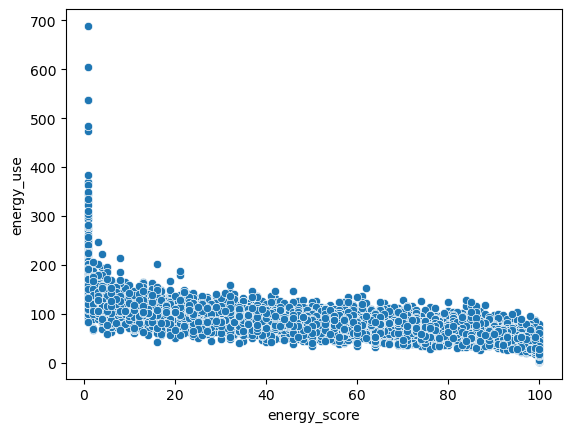

In [116]:
sns.scatterplot(df, x='energy_score', y='energy_use');

In [101]:
np.corrcoef(df['energy_score'], df['energy_use'])

array([[ 1.        , -0.73764428],
       [-0.73764428,  1.        ]])